In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Add this import
#uploading the dataset from the correct directory
data_dir = './dataSet/training'
labels = os.listdir(data_dir)

# Create the lists to store image paths and labels
image_paths = []
label_list = []

# Iterate through each label folder
for label in labels:
    label_folder = os.path.join(data_dir, label)
    for filename in os.listdir(label_folder):
        if filename.endswith('.jpg'):  
            image_path = os.path.join(label_folder, filename)
            image_paths.append(image_path)
            label_list.append(label)

# Create a DataFrame
df = pd.DataFrame({
    'Image': image_paths,
    'label': label_list
})

# Display the size of the DataFrame
print("DataFrame size:", df.size)
df.head


train_df, validate_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])


DataFrame size: 34226


In [2]:

img_width, img_height = 128, 128
batch_size = 32

# Training image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Image',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

# Validation image data generator
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    x_col='Image',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])




Found 11979 validated image filenames belonging to 27 classes.
Found 5134 validated image filenames belonging to 27 classes.


In [3]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_df.shape[0] // batch_size,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0] // batch_size,
    callbacks=callbacks
)

Epoch 1/3
374/374 [==============================] - ETA: 0s - loss: 1.9766 - accuracy: 0.3988
Epoch 1: val_loss improved from inf to 0.20533, saving model to model-best-gray.h5


C:\Users\amit kumar bhambhu\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


374/374 [==============================] - 254s 673ms/step - loss: 1.9766 - accuracy: 0.3988 - val_loss: 0.2053 - val_accuracy: 0.9488
Epoch 2/3
374/374 [==============================] - ETA: 0s - loss: 0.6227 - accuracy: 0.7905
Epoch 2: val_loss improved from 0.20533 to 0.04992, saving model to model-best-gray.h5
374/374 [==============================] - 247s 659ms/step - loss: 0.6227 - accuracy: 0.7905 - val_loss: 0.0499 - val_accuracy: 0.9896
Epoch 3/3
374/374 [==============================] - ETA: 0s - loss: 0.3629 - accuracy: 0.8788
Epoch 3: val_loss did not improve from 0.04992
374/374 [==============================] - 471s 1s/step - loss: 0.3629 - accuracy: 0.8788 - val_loss: 0.1100 - val_accuracy: 0.9492


In [27]:
model_json = model.to_json()
with open("model-gray-3.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model-gray-3.h5")
print("Saved model to disk")

Saved model to disk


<Figure size 640x480 with 0 Axes>

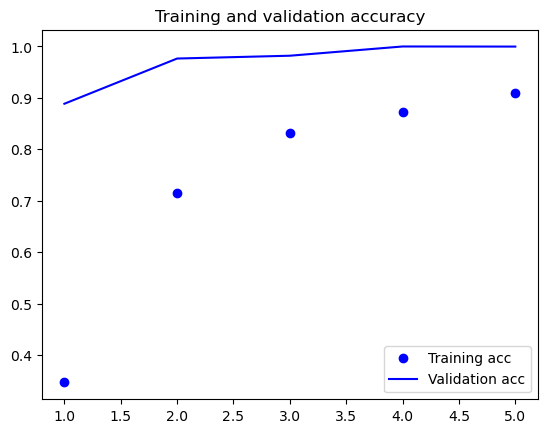

<Figure size 640x480 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

1/1 [==============================] - 0s 40ms/step
True Label:  I
Predicted Label:  I


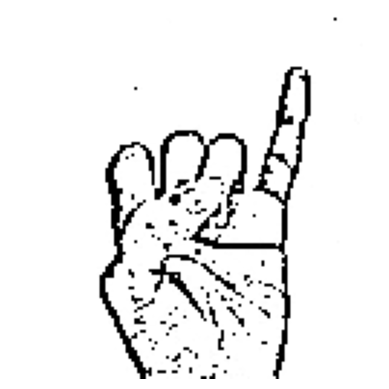

In [36]:
#for manual testing 

from tensorflow.keras.preprocessing import image
from random import randint
import numpy as np
# Choose a random image from the test dataset
random_index = randint(0, len(validate_df) - 1)
img_path = validate_df.iloc[random_index]['Image']
true_label = validate_df.iloc[random_index]['label']

img = image.load_img(img_path, target_size=(img_width, img_height), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize the image

img_array = np.expand_dims(img_array, axis=0)

#model prediction
prediction = model.predict(img_array)
predicted_label = labels[np.argmax(prediction)]

# Display the true and predicted labels of the model
print("True Label: ", true_label)
print("Predicted Label: ", predicted_label)

# Display the image with correct output i.e true and predicted labels
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


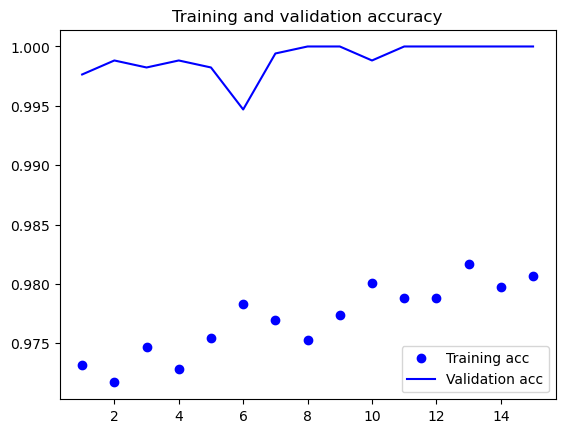

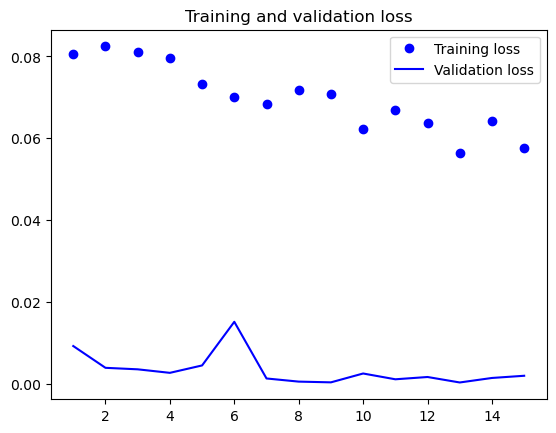

In [57]:
# Optional: plot the training history
import matplotlib.pyplot as plt

# Training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Show the plot
plt.show()

# Create a new figure for loss plots
plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Show the plot
plt.show()


In [7]:

# Model summary to get the number of parameters(to analyse the whoel model)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 128)      

In [ ]:
#plotting the confusion matrix and classifiaction report

1/1 [==============================] - 0s 35ms/step


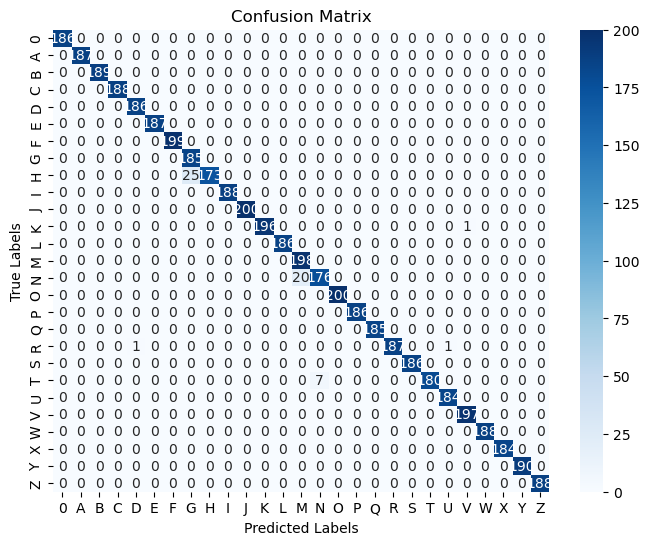

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_true=[]
y_pred = []

# Iterate through each row in the DataFrame
for index, row in validate_df.iterrows():
    img_path = row['Image']
    true_label = row['label']
    
    # Loading and preprocessing the image
    img = image.load_img(img_path, target_size=(img_width, img_height), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  

    # Reshaping the image to (1, img_width, img_height, 1) to match the model's expected input shape i.e gray scale
    img_array = np.expand_dims(img_array, axis=0)

    # Get model prediction
    prediction = model.predict(img_array)
    predicted_label = labels[np.argmax(prediction)]
    y_true.append(true_label)
    y_pred.append(predicted_label)
    
    
# generating the confusion matrices
conf_matrix = confusion_matrix(y_true, y_pred)

# Displaying the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [44]:
# classification report for our model
print("Classification Report:\n", classification_report(y_true, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       186
           A       1.00      1.00      1.00       187
           B       1.00      1.00      1.00       189
           C       1.00      1.00      1.00       188
           D       0.99      1.00      1.00       186
           E       1.00      1.00      1.00       187
           F       1.00      1.00      1.00       199
           G       0.88      1.00      0.94       185
           H       1.00      0.87      0.93       198
           I       1.00      1.00      1.00       188
           J       1.00      1.00      1.00       200
           K       1.00      0.99      1.00       197
           L       1.00      1.00      1.00       186
           M       0.91      1.00      0.95       198
           N       0.96      0.90      0.93       196
           O       1.00      1.00      1.00       200
           P       1.00      1.00      1.00       186
   